In [1]:
%config InlineBackend.figure_formats = {"retina", "png"}

import time
import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 14
import matplotlib.colors as cm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

import superscreen as sc

In [195]:
length_units = "um"

layers = [
    sc.Layer("base", Lambda=1, z0=0),
]

films = [
    sc.Polygon(
        "disk",
        layer="base",
        points=sc.geometry.circle(5, points=401),
    ),
]

abstract_regions = [
    sc.Polygon(
        "bounding_box",
        layer="base",
#         points=sc.geometry.circle(7, points=51),
        points=sc.geometry.square(12, points_per_side=11),
    ),
]

disk = sc.Device(
    "disk",
    layers=layers,
    films=films,
    abstract_regions=abstract_regions,
    length_units=length_units,
)

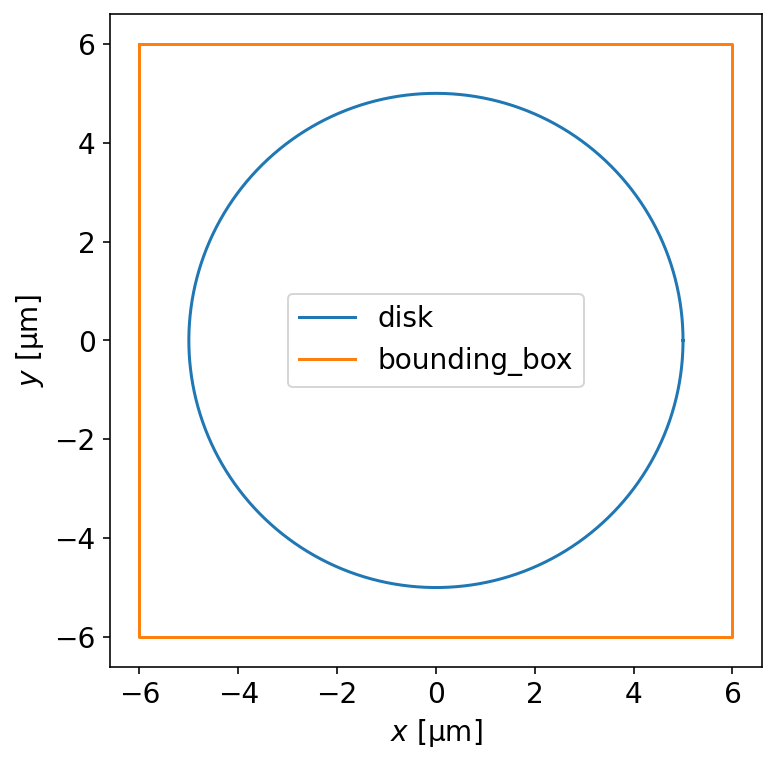

In [196]:
ax = disk.plot_polygons(figsize=(6, 6))

In [250]:
disk.make_mesh(min_triangles=8000, optimesh_steps=100)

INFO:superscreen.device:Generating mesh...
INFO:superscreen.device:Optimizing mesh with 8092 triangles.
INFO:superscreen.device:Finished generating mesh with 4128 points and 8092 triangles.
INFO:superscreen.device:Calculating weight matrix.
INFO:superscreen.device:Calculating Laplace operator.
INFO:superscreen.device:Calculating kernel matrix.


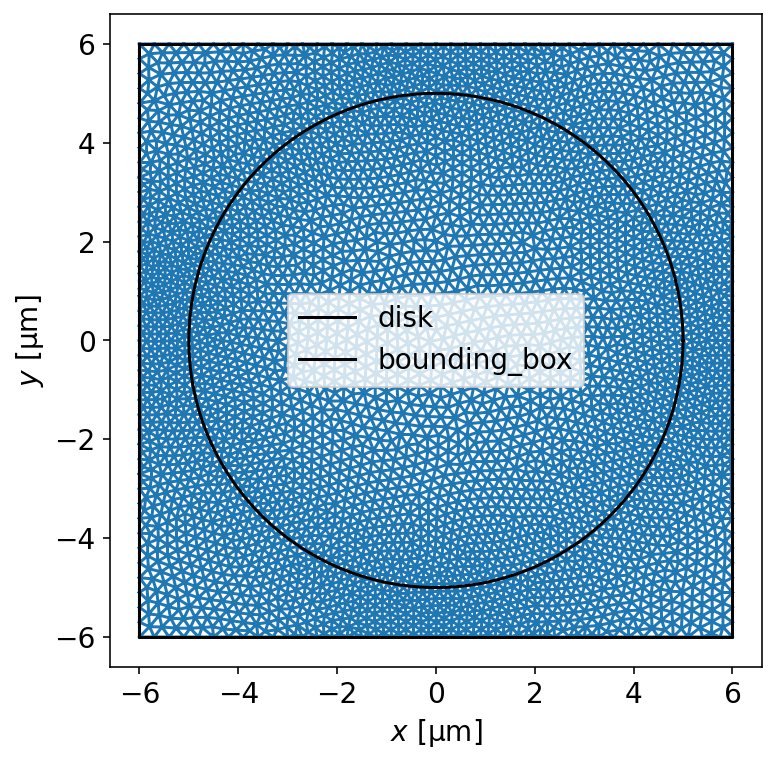

In [251]:
ax = disk.plot_mesh(figsize=(6, 6))
ax = disk.plot_polygons(ax=ax, color="k")

In [290]:
field_units = "mT"

applied_field = sc.sources.ConstantField(1)

Lambdas = np.logspace(-1, 1, 5)

solutions = []

for Lambda in Lambdas:
    disk.layers["base"].Lambda = Lambda
    
    solutions.append(
        sc.solve(
            device=disk,
            applied_field=applied_field,
            field_units=field_units,
        )[-1]
    )

INFO:superscreen.brandt:Calculating base response to applied field.
INFO:superscreen.brandt:Calculating base response to applied field.
INFO:superscreen.brandt:Calculating base response to applied field.
INFO:superscreen.brandt:Calculating base response to applied field.
INFO:superscreen.brandt:Calculating base response to applied field.


In [291]:
# for solution in solutions:
#     fig, axes = solution.plot_currents(
#         cross_section_ys=[0],
#         streamplot=False,
#         figsize=(6, 6),
#     )

In [292]:
# for solution in solutions:
#     fig, axes = solution.plot_fields(
#         grid_shape=500,
#         cross_section_ys=[0],
#         figsize=(6, 6),
#     )

In [377]:
def plot_solutions(solutions, Lambdas, figsize=(14, 10), grid_shape=200, cmap="viridis", lw=2.5):
    N = grid_shape // 2

    fig, axes = plt.subplots(2, 2, figsize=figsize)
    # (ax, bx), (cx, dx), (ex, fx) = axes
    (ax, bx), (cx, dx) = axes
    ax.set_aspect("equal")
    bx.set_aspect("equal")
    cx.grid(True)
    dx.grid(True)
    # ex.grid(True)
    # fx.grid(True)

    colors = plt.get_cmap(cmap)(np.linspace(0, 1, len(Lambdas)))

    for i, (solution, Lambda, color) in enumerate(zip(solutions, Lambdas, colors)):

        xgrid, ygrid, fields = solution.grid_data("fields", grid_shape=grid_shape)
        field = fields["base"]

        if Lambda == 1:
            im = ax.pcolormesh(xgrid, ygrid, field, shading="auto", cmap="cividis")
            ax.set_xlabel("$x$ [$\\mu$m]")
            ax.set_ylabel("$y$ [$\\mu$m]")
            ax.set_title("Magnetic field, $\\mu_0H_z$\n$\\Lambda$ = 1 $\\mu$m")
            ax_divider = make_axes_locatable(ax)
            cax = ax_divider.append_axes("right", size="8%", pad="4%")
            cbar = fig.colorbar(im, cax=cax)
            cbar.set_label(f"$\\mu_0H_z$ [{solution.field_units}]")
            ax.axhline(xvec[N], ls="--", color="w", lw=lw)
    
        xvec, yvec = sc.grids_to_vecs(xgrid, ygrid)
        cx.plot(xvec, field[N, :], color=color, lw=lw)
        # ex.plot(xvec, (field[N, :] - field[N, 0]) / np.nanmax(field[N, :]), color=color, lw=lw)

        xgrid, ygrid, jcs = solution.current_density(
            grid_shape=grid_shape, units="mA / um", with_units=True
        )
        jx, jy = jcs["base"].magnitude
        units = jcs["base"].units
        J = np.sqrt(jx**2 + jy**2)
        xvec, yvec = sc.grids_to_vecs(xgrid.magnitude, ygrid.magnitude)
        
        if i == 0:
            jxlabel = "$J_x$"
            jylabel = "$J_y$"
        else:
            jxlabel = jylabel = None

        dx.plot(xvec, jx[N, :], color=color, ls="--", lw=lw, label=jxlabel)
        dx.plot(xvec, jy[N, :], color=color, ls="-", lw=lw, label=jylabel)
        # fx.plot(xvec, jx[N, :] / np.nanmax(jx[N, :]), color=color, ls="--", lw=lw, label=jxlabel)
        # fx.plot(xvec, jy[N, :] / np.nanmax(jy[N, :]), color=color, ls="-", lw=lw, label=jylabel)

        if Lambda == 1:
            im = bx.pcolormesh(xvec, yvec, J, shading="auto", cmap="inferno")
            bx.set_xlabel("$x$ [$\\mu$m]")
            bx.set_ylabel("$y$ [$\\mu$m]")
            bx.set_title("Sheet current, $|\\vec{J}|$\n$\\Lambda$ = 1 $\\mu$m")
            ax_divider = make_axes_locatable(bx)
            cax = ax_divider.append_axes("right", size="6%", pad="4%")
            cbar = fig.colorbar(im, cax=cax)
            cbar.set_label("$|\\vec{J}|$" + f" [{units:~P}]") 
            bx.axhline(xvec[N], ls="--", color="w", lw=lw)
            jx[J < 0.075 * np.nanmax(J)] = np.nan
            jy[J < 0.075 * np.nanmax(J)] = np.nan
            bx.streamplot(xgrid.m, ygrid.m, jx, jy, color="w", density=1.25, linewidth=1)


    cx.set_xlabel("$x$ [$\\mu$m]")
    cx.set_ylabel(f"$\\mu_0H_z$ [{solution.field_units}]")
    # ex.set_xlabel("$x$ [$\\mu$m]")
    # ex.set_ylabel(f"$\\mu_0H_z$ / max($\\mu_0H_z$)")

    dx.set_xlabel("$x$ [$\\mu$m]")
    dx.set_ylabel(f"$J_x$, $J_y$ [{units:~P}]") 
    dx.legend(loc=1)

    # fx.set_xlabel("$x$ [$\\mu$m]")
    # fx.set_ylabel(f"$J_x$ / max($J_x$), $J_y$ / max($J_y$)") 
    # fx.legend(loc=1)
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.cm.LogNorm(Lambdas.min(), Lambdas.max()))
    cbar = fig.colorbar(sm, ax=(cx, dx), orientation="horizontal", aspect=50, pad=0.25)
    cbar.set_label(f"Effective penetration depth, $\\Lambda$ [{xgrid.units:~P}]")

    return fig, axes

AttributeError: module 'matplotlib.cm' has no attribute 'LogNorm'

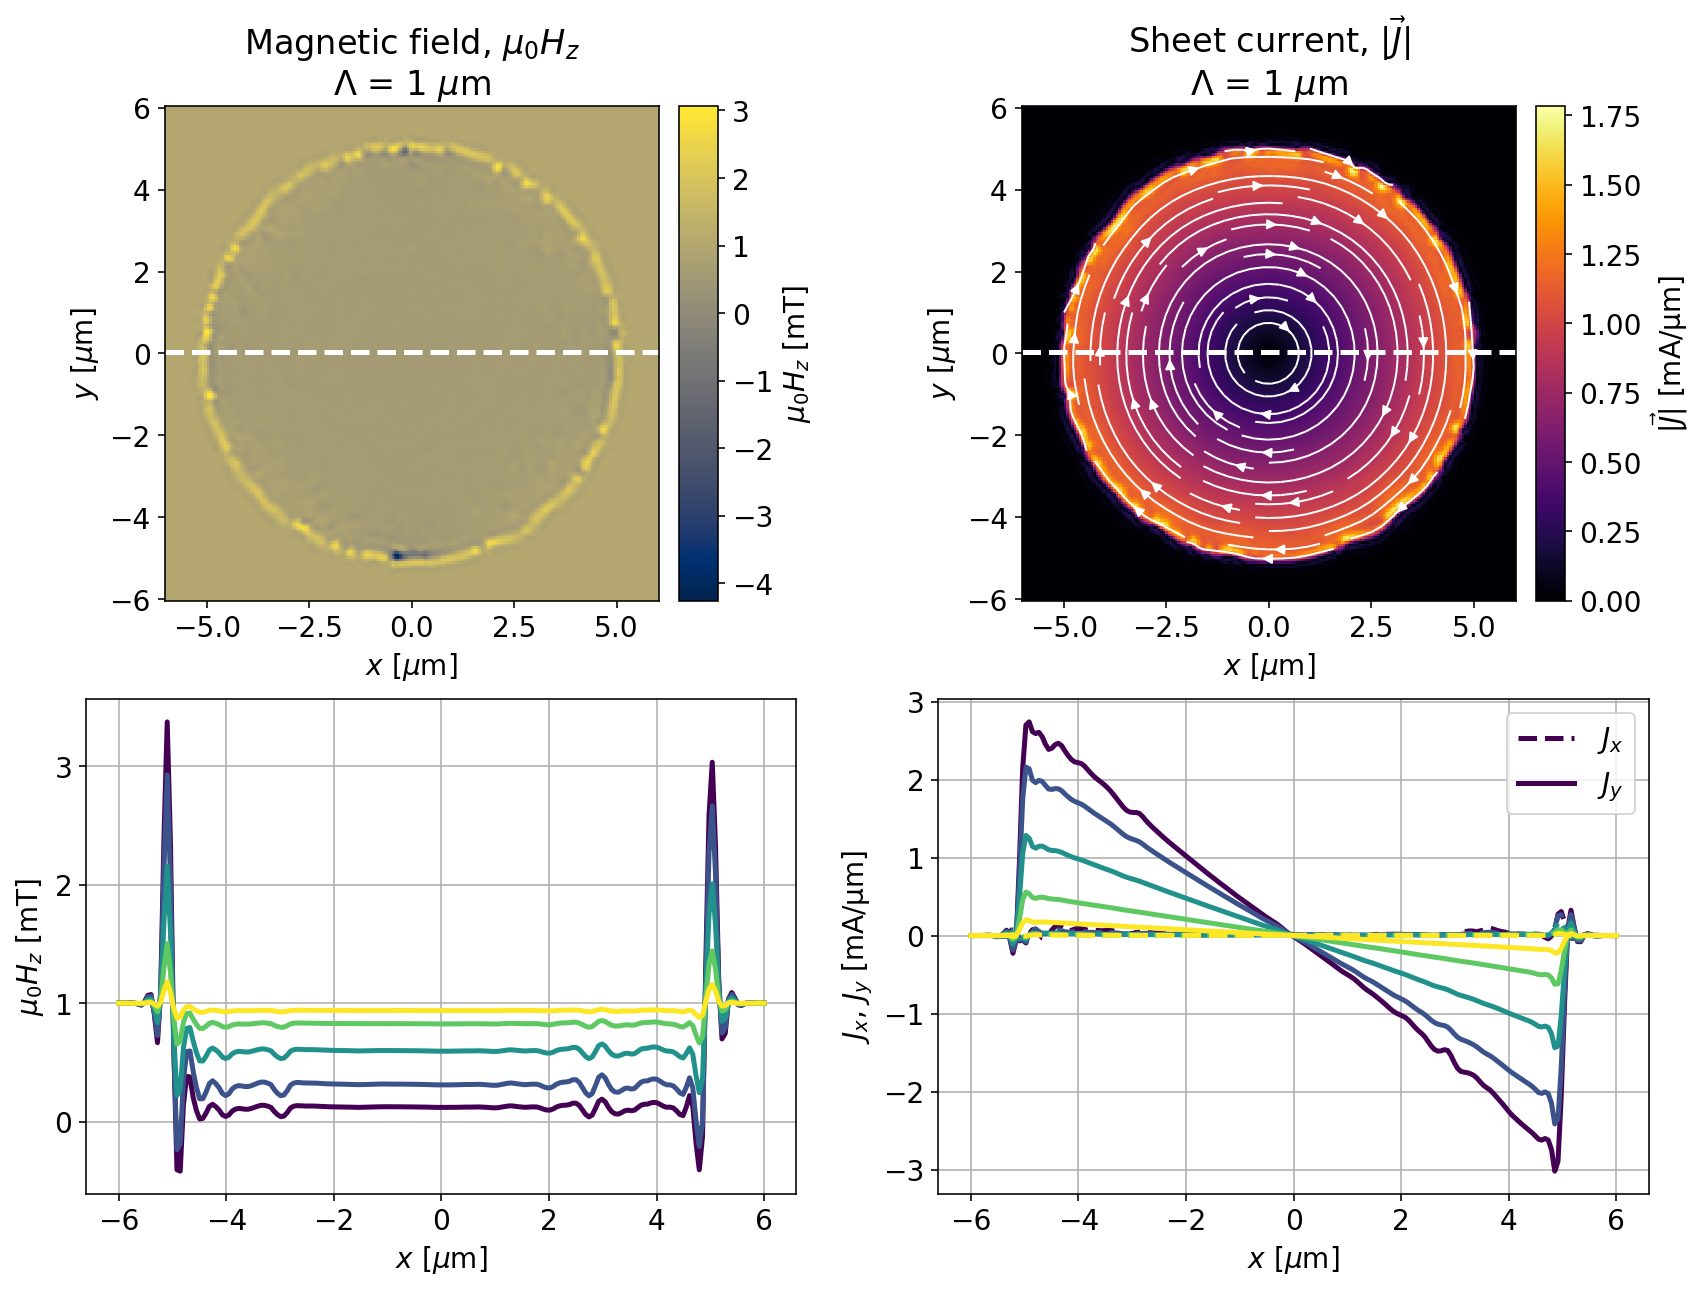

In [378]:
fig, axes = plot_solutions(solutions, Lambdas)

In [382]:
def Lambda_at_position(x, y, Lambda0=0, Lambda1=0):
    Lambda = (
        Lambda0
        + (Lambda1 - Lambda0) * ((x - x.min()) / np.ptp(x))
    )
    print(Lambda[np.argmin(x)], Lambda[np.argmax(x)])
    return Lambda

Lambda = sc.Parameter(Lambda_at_position, Lambda0=1, Lambda1=100)

disk.layers["base"].Lambda = Lambda

In [383]:
solution = sc.solve(
    device=disk,
    applied_field=applied_field,
    field_units=field_units,
)[-1]

INFO:superscreen.brandt:Calculating base response to applied field.


1.0 100.0


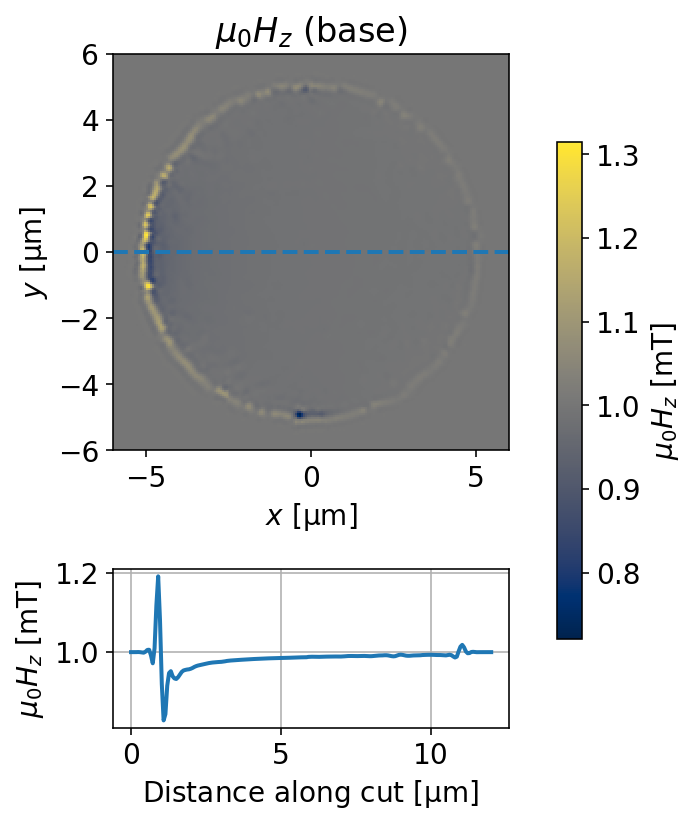

In [374]:
fig, axes = solution.plot_fields(figsize=(5, 6), cross_section_ys=[0])

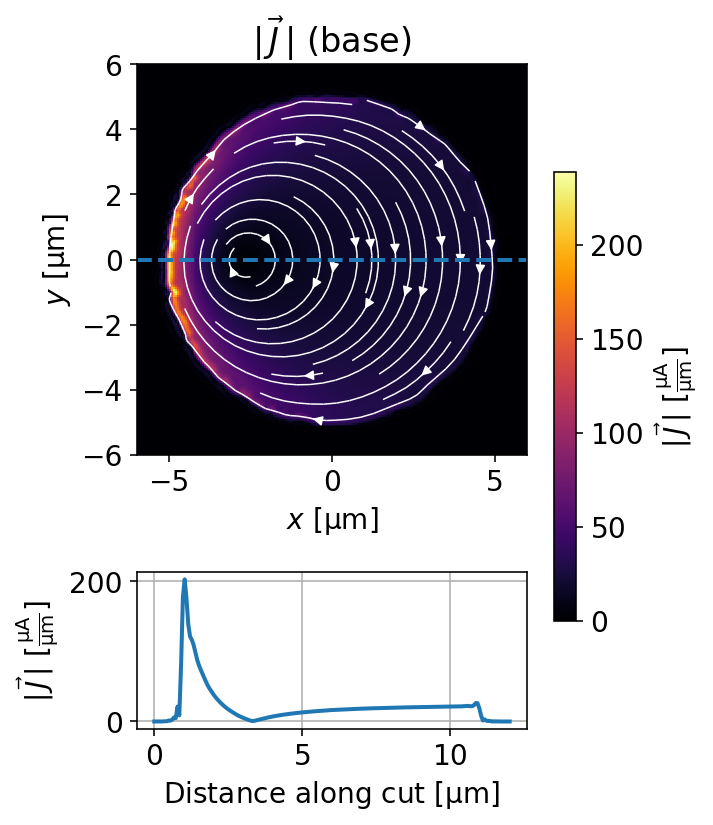

In [376]:
fig, axes = solution.plot_currents(figsize=(5, 6), cross_section_ys=[0])